In [1]:
%pylab inline
import scipy
from scipy import misc
from scipy import ndimage
from skimage import feature
from skimage.transform import (hough_line, hough_line_peaks,probabilistic_hough_line)

from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter

import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
face = misc.face()

(-0.5, 1023.5, 767.5, -0.5)

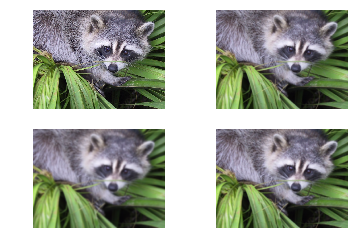

In [3]:
blurred_face = ndimage.gaussian_filter(face, sigma=(3, 3, 0))
very_blurred_face = ndimage.gaussian_filter(face, sigma=(5, 5, 0))
local_mean_face = ndimage.uniform_filter(face, size=(11, 11, 0))

plt.subplot(221)
plt.imshow(face)
plt.axis('off')
plt.subplot(222)
plt.imshow(blurred_face)
plt.axis('off')
plt.subplot(223)
plt.imshow(very_blurred_face)
plt.axis('off')
plt.subplot(224)
plt.imshow(local_mean_face)
plt.axis('off')

In [4]:
im = np.zeros((256, 256))
im[64:-64, 64:-64] = 1

im = ndimage.rotate(im, 15, mode='constant', reshape=False)
im = ndimage.gaussian_filter(im, 3)

# Sobel Filter

Sobel calcula el gradiente de las imágenes. Este es máximo cuando hay un cambio de color. Así puede detectar bordes.

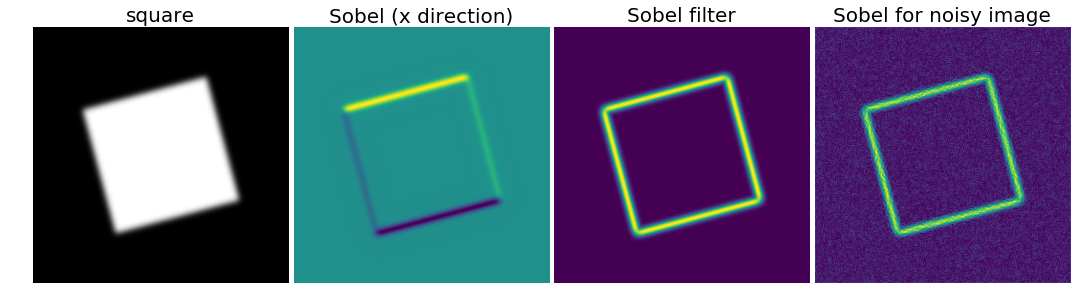

In [5]:
sx = ndimage.sobel(im, axis=0, mode='constant')
sy = ndimage.sobel(im, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.figure(figsize=(16, 5))
plt.subplot(141)
plt.imshow(im, cmap=plt.cm.gray)
plt.axis('off')
plt.title('square', fontsize=20)
plt.subplot(142)
plt.imshow(sx)
plt.axis('off')
plt.title('Sobel (x direction)', fontsize=20)
plt.subplot(143)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel filter', fontsize=20)

im_noisy = im + 0.07*np.random.random(im.shape)

sx = ndimage.sobel(im_noisy, axis=0, mode='constant')
sy = ndimage.sobel(im_noisy, axis=1, mode='constant')
sob = np.hypot(sx, sy)

plt.subplot(144)
plt.imshow(sob)
plt.axis('off')
plt.title('Sobel for noisy image', fontsize=20)



plt.subplots_adjust(wspace=0.02, hspace=0.02, top=1, bottom=0, left=0, right=0.9)

plt.show()

# Canny Filter

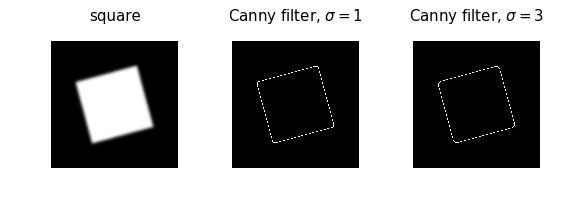

In [6]:
# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('square', fontsize=15)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=15)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=15)

plt.tight_layout()

plt.show()

# Trasformada de Hough

Para cada punto que encuentra el filtro Canny, la transormada de Hough detecta todas las líneas posibles que puede pasar por ese punto. Cuando hace eso para tofosw los puntos del filtro Canny, hay una línea que va a tener muchos puntos en común y esas es la que pinta. 

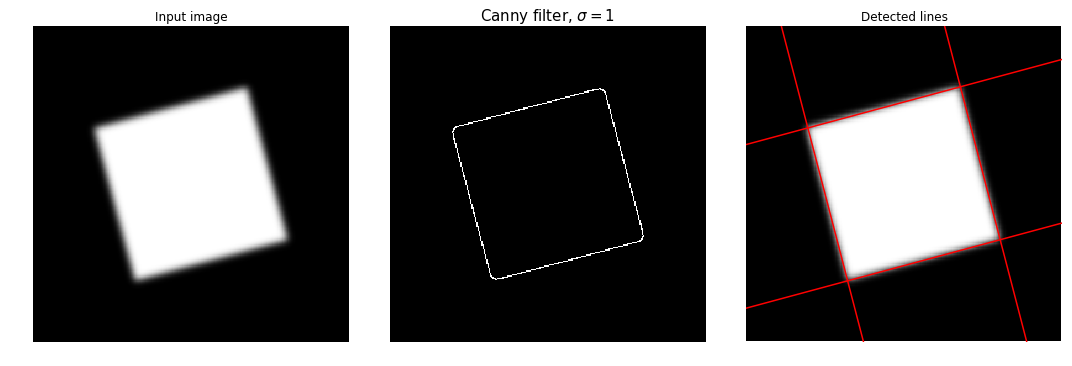

In [7]:
h, theta, d = hough_line(edges1)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(im, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges1, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Canny filter, $\sigma=1$', fontsize=15)

ax[2].imshow(im, cmap=cm.gray)
for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
    y1 = (dist - im.shape[1] * np.cos(angle)) / np.sin(angle)
    ax[2].plot((0, im.shape[1]), (y0, y1), '-r')
ax[2].set_xlim((0, im.shape[1]))
ax[2].set_ylim((im.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')
plt.tight_layout()
plt.show()

# Vesícula

In [31]:
# Importar la imagen con OpenCV
ves = cv2.imread('Ves_Image.jpg',0) # Importarla en grayscale para poder aplicar Canny
ves_color = cv2.imread('Ves_Image.jpg')

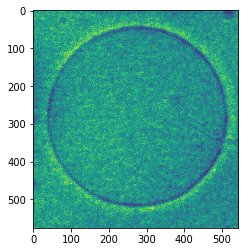

In [9]:
plt.imshow(ves)

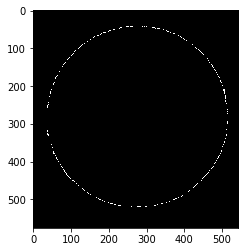

In [40]:
# Aplicar el filtro Canny del scipy toolkit skimage - funciona más fácil que el de OpenCV 
edges_ves = feature.canny(ves, sigma=3.45)
plt.imshow(edges_ves, cmap='gray')

In [41]:
# Definir una función que intenta detectar los límites superiores e inferiores 
# para aplicar el filtro Canny de OpenCV

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
 
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
 
    # return the edged image
    return edged

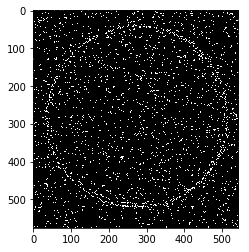

In [42]:
# Aplicar la función de auto_canny a la imagen
prueba = auto_canny(ves,0.15)
plt.imshow(prueba,cmap="gray")

In [44]:
# Aplicar la transformada de Hough Circular para detectar los círculos en la imagen

# Crear un arreglo con estimaciones de los radios para que la función de hough_circle de skimage los use
# Entre más pasos haya en el vector de predicción, más preciso puede ser el Hough Transform
hough_radii = np.arange(200, 310, 1)  
hough_res = hough_circle(edges_ves, hough_radii)
#hough_res = hough_circle(prueba, hough_radii)

In [61]:
# Identificar los círculos más prominentes con centros separados por cierta distancia (1 por default)
# Se puede espicifcar cuantos círculos prominentes detectar - en este caso sólo se quiere 1
# http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.hough_circle_peaks
# Accums = peak values, cx = x coordinate for center, cy = y coordinate for center, radii = radii of circles
accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1)

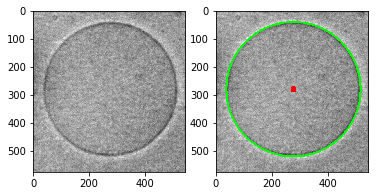

In [62]:
# Crear una copia de la imagen para no dañar la original
output = ves_color.copy()

# Plot la original
plt.subplot(121)
plt.imshow(ves_color)

# Pintar el círculo y el centro sobre la copia de la imagen
for x in cx:
    for y in cy:
        for r in radii: 
            cv2.circle(output, (x,y), r, (0,255,0),5)
            cv2.circle(output, (x,y), 1, (255,0,0),20)

# Plot la nueva imagen
plt.subplot(122)            
plt.imshow(output)